## Using LSTMs to Predict Mid-Price Movement from the Limit Order Book

### Overview
- This notebook provides an example of how TensorFlow can be used to train and test a Long-Short Term Memory (a type of recurrent neural network) architecture for classification of mid-price movements from time series of limit order book updates. 

- Recurrent neural networks are well suited to classification from time series (a.k.a. sequence classification) and time series regression. Unlike typical time series methods, e.g. GARCH, there are no parameteric assumptions on the distribution of the predictors. 

- The goal of the LSTM predictor is to predict whether the mid-price will remain stationary, tick-up or tick-down in the next period.


#### Quant's guide to machine learning
- We choose to build a model which provides strong predictive power, in favor of explantory power. 
- Our choice to use a recurrent neural network is predicated on each observation in the time series being dependent on previous observations. The ordering of the observations therefore matters and $X$ is not iid.
- Once the input data is appropriately scaled, model building starts with 'feature selection' -identifying the relevant features to include in the model. Elastic net or LARS are common techniques for automatic variable selection. Other techniques, commonly used with neural network architectures include auto-encoders. 
- In this tutorial, we assume that we've already identifed the relevant set of features. 
- Our primary concern in assessing the extent to which the classifier is over-fitting.

### Disclaimer
- This is not an engineer's tutorial on how to use TensorFlow. We believe that a more statistical approach to describing how to use TensorFlow is insightful.
- We do not claim that the LSTM is superior in performance to any other method, including classical econometrics methods adapted for classification with a logistic link function.

- Due to licensing restrictions, the example time series data is fictitious and designed to be representative of tick level data.

- For the purposes of this tutorial, the training and testing phases have been simplified. A more robust approach would use time-series cross validation and typically split the dataset into three disjoint sub-sets to allow for training, verification (a.k.a. tuning) and testing.

- The integration of the classifier with a strategy backtesting environment is not described here.

- This notebook has been tested in a virtual environment run on a MAC and Linux. It has not been tested on Windows.

In [1]:
%matplotlib inline

In [2]:
# import os

# module_path = os.path.abspath(os.path.join('../..')) 

We have overriden some native TensorFlow functions to allow for more flexibility. Let's import these modules here.

In [3]:
# import sys
# if module_path not in sys.path:
#     sys.path.append(module_path)

# from core.ml_analysis import MLOperator, MLEvaluator
from ml_analysis import MLOperator, MLEvaluator

In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
from sklearn.metrics import f1_score

Import the necessary set of modules from Keras

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.


### Example Data
- The example dataset is a chronologically ordered time series. Each observation is recorded at each limit order book update. The ordering of the observations matters and each observation is not assumed to be independent (as with cross-sectional classification data). 

- For simplicity, since the timestamps are not important for this tutorial, an integer index has been used for the Pandas Dataframe. A real dataset would typically be indexed by a unique timestamp. 

- Each observation $X$ has three variables (a.k.a. features) representing the liquidity and best limit order price quotes in the book. To predict whether the mid-price will tick-down, remain the same or tick-up, each observation is labelled by the categorical response variable $Y\in\{-1,0,1\}$ respectively.  


Loading the Pandas Dataframe, viewing the first ten rows and the distribution of the labels:

In [6]:
df = pd.read_csv('data/HFT.csv')

In [7]:
df.head()

,feature_1,feature_2,feature_3,label
0,0.515301,0.72,0.710953,0
1,0.515301,0.72,0.710953,0
2,0.515301,0.72,0.710953,0
3,0.515301,0.72,0.710953,0
4,0.515301,0.72,0.710953,0


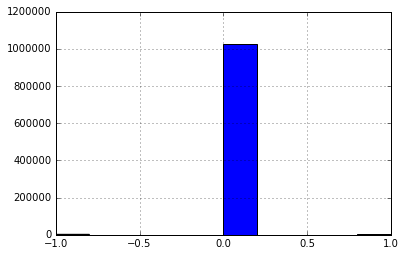

In [8]:
df.label.hist()

In [9]:
df.label.value_counts()

 0    1028280
 1       2629
-1       2623
Name: label, dtype: int64

We observe that there is a class imbalance problem. Proceeding without correcting for the imbalance will lead to spurious results. 

Our exposition includes examples of exploratory data analysis, designed to provide intuition into the level of non-linearity in the map $Y=F(X)$. Let's first view the distribution of our features by each label 0,-1, then 1. 

*Note: We just consider feature_1, but you should check the other features too.*

0


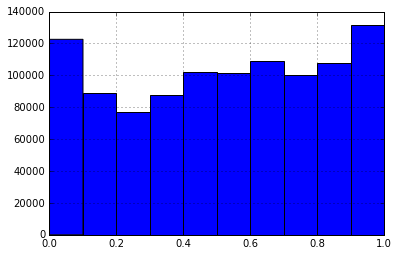

-1


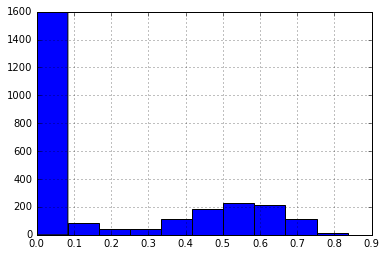

1


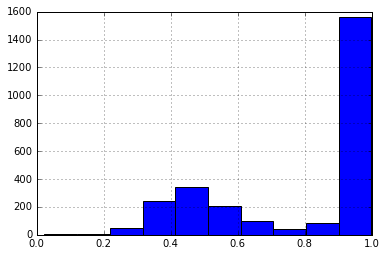

In [10]:
for lab in df.label.unique():
    print lab
    df.feature_1[df.label==lab].hist()
    plt.show()
    plt.close()

### Preparation of the training and testing sets

We use a simple 80/20 splitting rule, ensuring that the training set pre-dates the testing set (to avoid look-ahead bias).

In [11]:
train_weight = 0.8
split = int(len(df)*train_weight)
df_train = df[:split]
df_test = df[split:]

Let's instantiate our MLOperator class which will be used for performing high-level data processing tasks on top of Keras.

In [12]:
operator = MLOperator()

### Sampling

**Training Set**: Resolve the time series class imbalance problem by sampling in a neighborhood of the up and down ticks. We choose this neighborhood to be a lagging window of size 20. Although simplistic, this preserves at least some of the covariance structure in the time series data.

**Testing Set**: Do not sample - leave imbalanced.

In [13]:
n_steps = 20
use_features = ['feature_1']
y_train = df_train.label

In [14]:
sampled_idx = operator.get_samples_index(y_train.iloc[n_steps-1:], 'min')

In [15]:
x_train = df_train[use_features]
y_test = df_test.label.iloc[n_steps-1:]
x_test = df_test[use_features]

### Data formatting for LSTMs

Let's define the following function for reshaping the data into times series classification format. For example, consider a univariate time series of increasing integers

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

Setting the sequence length to 10, we move the window forward by one observation at a time and construct new sequences:

1 2 3 4 5 6 7 8 9 10

2 3 4 5 6 7 8 9 10 11

3 4 5 6 7 8 9 10 11 12

4 5 6 7 8 9 10 11 12 13

5 6 7 8 9 10 11 12 13 14

6 7 8 9 10 11 12 13 14 15

In [16]:
def get_LSTM_data(x_train, y_train, x_test, y_test, sampled_idx, n_steps):
    # training set
    x_train_m = x_train.as_matrix()
    x_train_list = []
    for idx in sampled_idx:
        int_idx = y_train.index.get_loc(idx)
        x_train_list.append(x_train_m[(int_idx-n_steps+1):int_idx+1])

    x_train = np.array(x_train_list)
    y_train = pd.get_dummies(y_train[sampled_idx]).as_matrix()

    # test set
    x_test_m = x_test.as_matrix()
    x_test_list = []
    for i in range(x_test.shape[0] - n_steps+1):
        x_test_list.append(x_test_m[i: (i + n_steps)])
    x_test = np.array(x_test_list)

    y_test = pd.get_dummies(y_test).as_matrix()
    
    return x_train, y_train, x_test, y_test

In [17]:
x_train, y_train, x_test, y_test = get_LSTM_data(x_train, y_train, x_test, y_test, sampled_idx, n_steps)

In [18]:
nrow = 3000
x_valid = x_test[0:nrow]
y_valid = y_test[0:nrow]
x_test = x_test[nrow:]
y_test = y_test[nrow:]

In [19]:
print x_train.shape,y_train.shape,x_test.shape,y_test.shape, x_valid.shape, y_valid.shape

(6294, 20, 1) (6294, 3) (203688, 20, 1) (203688, 3) (3000, 20, 1) (3000, 3)


## LSTM Model Specification

We now proceed with the model specification in Keras. Consistent with the window size, we specify a ten layer LSTM network and squash each unit output with a softmax function.

In [20]:
model = Sequential()
model.add(LSTM(10, stateful=False, input_shape=(x_train.shape[1], x_train.shape[-1])))
model.add(Dense(y_train.shape[1], activation='softmax'))

In [21]:
# Configurations
initial_lrate = 0.0001

In [22]:
adagrad = optimizers.Adagrad(lr=initial_lrate, epsilon=1e-08, decay=0.0)
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [23]:
callbacks_list = list()

In [24]:
# learning rate schedule
# LearningRate = InitialLearningRate * DropRate^floor(Epoch / EpochDrop)
# Or: decrease half of the learning rate after every epochs_drop (20 epochs for example)
def step_decay(epoch):
    lrate = initial_lrate
    epochs_drop = 70
    drop = 0.5
    if (epoch % epochs_drop == 0):
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        print("Decreased Learning Rate to: {}".format(lrate))
    return lrate

In [25]:
lrate = LearningRateScheduler(step_decay)

In [26]:
callbacks_list.append(lrate)

In [27]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [28]:
# initial settings
n_epoch = 2000
n_batch = 500
last_epoch_th = 0

In [29]:
%%time
history = model.fit(x_train, y_train, epochs=n_epoch, batch_size=n_batch, verbose=1,
          validation_data=(x_valid, y_valid), shuffle=True, callbacks = callbacks_list, 
                    initial_epoch = last_epoch_th)

Train on 6294 samples, validate on 3000 samples
Decreased Learning Rate to: 0.0001
Epoch 1/2000
6294/6294 [==============================] - 1s - loss: 1.1046 - acc: 0.2666 - val_loss: 1.0960 - val_acc: 0.6530
Epoch 2/2000
3000/6294 [=============>................] - ETA: 0s - loss: 1.1030 - acc: 0.3353

KeyboardInterrupt: 

### Serialization
If no further adjustments to the training are needed then we can save the model to HDF5 format and simply reload it in future notebook sessions. 

In [ ]:
# save the model
model.save('model/lstm.hdf5', overwrite=True)  # creates a HDF5 file 'my_model.h5'

In [ ]:
hist = history.history

In [ ]:
history_path = "history/lstm_history.json"
with open(history_path, 'w') as fp:
    json.dump(hist, fp)

## Prediction

In [30]:
# returns a compiled model
# identical to the previous one
model = load_model('model/lstm.hdf5')

In [32]:
%%time
pred_df_train, pred_df_test, _ = operator.get_pred_dfs(x_train, x_test, y_train, y_test, 
                                                       classifier='tensorflow', model=model, 
                                                       columns=['-1', '0', '1'])

CPU times: user 1min 21s, sys: 56.6 s, total: 2min 17s
Wall time: 1min 22s


In [33]:
train_f1 = f1_score(pred_df_train.true, pred_df_train.predict, average=None)
test_f1 = f1_score(pred_df_test.true, pred_df_test.predict, average=None)
print train_f1
print test_f1

[ 0.77281106  0.74409251  0.76955504]
[ 0.02784449  0.84006876  0.02666575]


## Model Evaluation

We instantiate our MLEvaluator class to store the performance results of the classifier.

In [34]:
evaluator = MLEvaluator()

As mentioned, our primary objective in assessing our LSTM model, is to evaluate the extent of over-fitting. One simple method for measuring the bias-variance tradeoff compares the performance of the model on the training and test set. We use confusion matrices and ROC curves to measure the performance.

Confusion matrix, without normalization
[[1677  205  216]
 [ 305 1480  313]
 [ 260  195 1643]]
Normalized confusion matrix
[[ 0.7993327   0.09771211  0.1029552 ]
 [ 0.14537655  0.70543375  0.1491897 ]
 [ 0.12392755  0.09294566  0.78312679]]


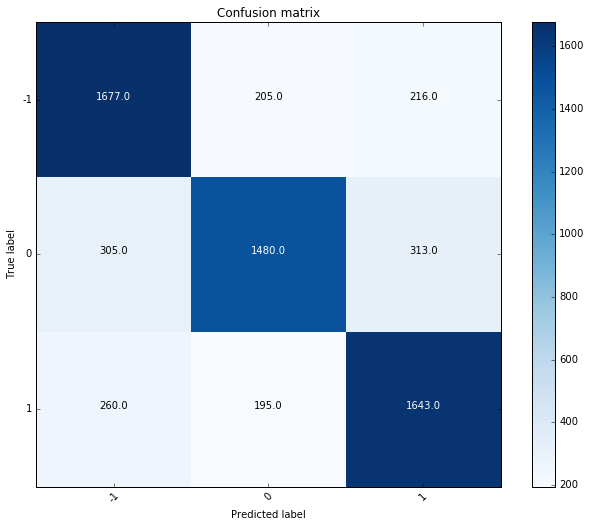

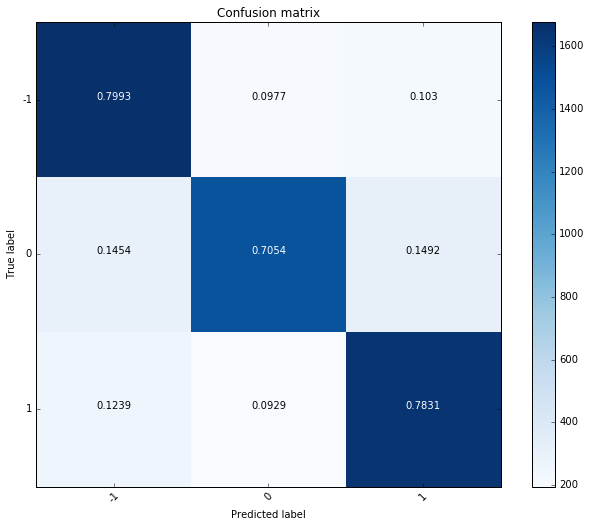

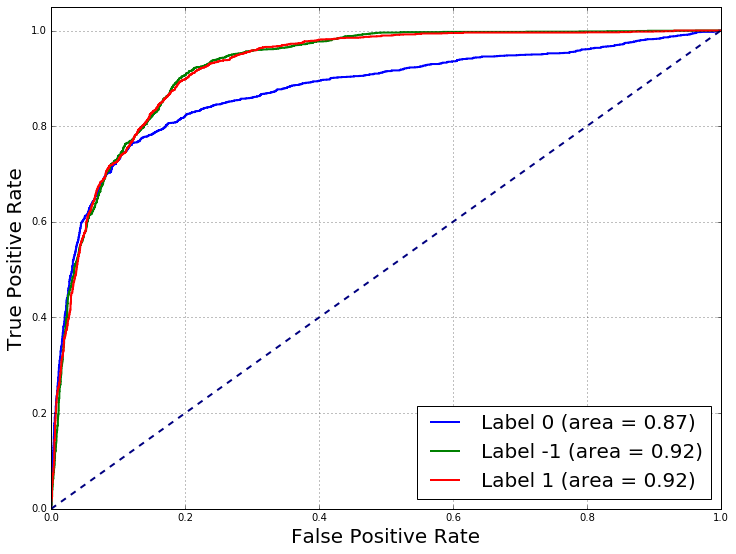

In [35]:
evaluator.set_pred_df(pred_df_train)
cf_mx_train = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_train.as_matrix(), [-1, 0, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_train.as_matrix(), [-1, 0, 1], 
    normalize=True)
fig = evaluator.plot_roc()

Confusion matrix, without normalization
[[   400     53     71]
 [ 27744 146852  28072]
 [    63     46    387]]
Normalized confusion matrix
[[ 0.76335878  0.10114504  0.13549618]
 [ 0.13689384  0.72459392  0.13851225]
 [ 0.12701613  0.09274194  0.78024194]]


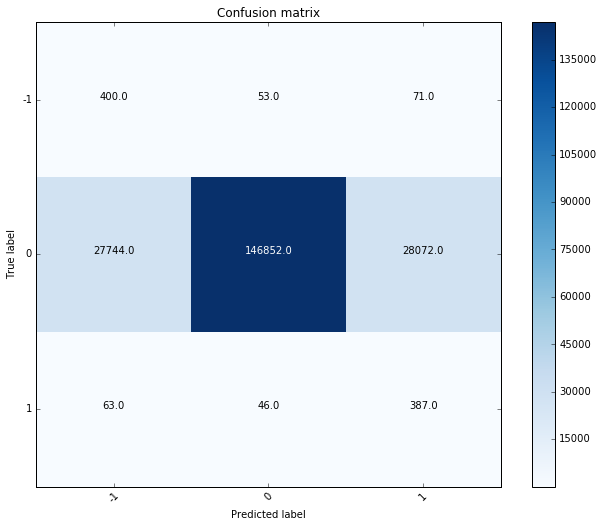

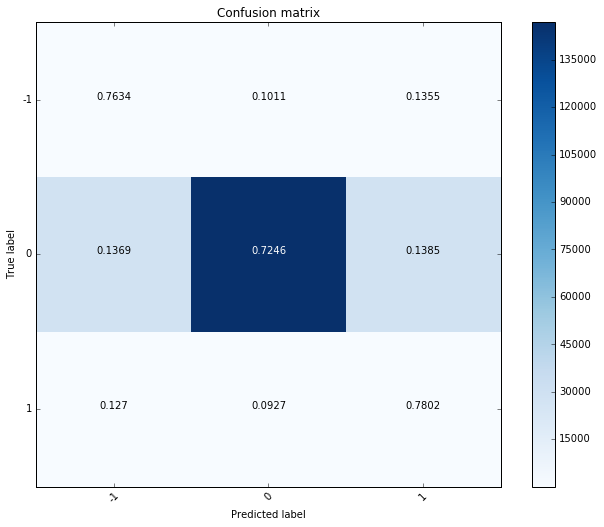

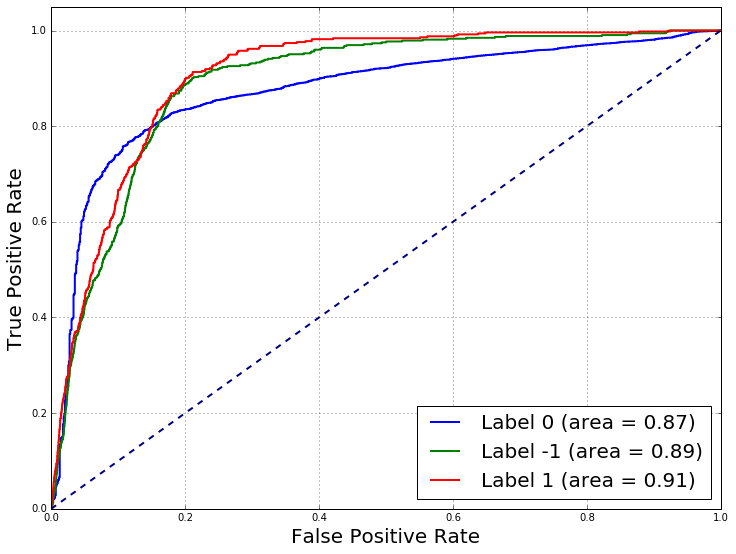

In [36]:
evaluator.set_pred_df(pred_df_test)
cf_mx_test = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_test.as_matrix(), [-1, 0, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_test.as_matrix(), [-1, 0, 1], 
    normalize=True)
fig = evaluator.plot_roc()

##  Learning Curves

We seek to evaluate the bias-variance tradeoff as a function of the size of the training set. This can address the question of whether the sample size is 'sufficient' for our classifier - we expect the performance on the test set to converge to that on the training set with increasing sample size.

In [37]:
y_train_bvt = df_train.label
x_train_bvt = df_train[use_features]
y_test_bvt = df_test.label.iloc[n_steps-1:]
x_test_bvt = df_test[use_features]

In [38]:
n_exp = 1
n_obs_list = range(100, len(sampled_idx)/3, 300)
print n_obs_list

# initial settings
n_epoch = 2000
n_batch = 500
last_epoch_th = 0

[100, 400, 700, 1000, 1300, 1600, 1900]


In [39]:
f1_df_list = []

In [40]:
bvt_callbacks_list = list()
bvt_callbacks_list.append(lrate)

In [41]:
for exp in range(n_exp):
    print 'experiment ', exp
    for n_obs in n_obs_list:
        print 'number of observations ', n_obs
        sampled_idx_sm = operator.get_samples_index(y_train_bvt.iloc[n_steps-1:], n_obs)
        print len(sampled_idx_sm)
        
        x_train_sm, y_train_sm, x_test_sm, y_test_sm = get_LSTM_data(x_train_bvt, y_train_bvt, x_test_bvt, y_test_bvt, 
                                                                     sampled_idx_sm, n_steps)
        
        print x_train_sm.shape,y_train_sm.shape,x_test_sm.shape,y_test_sm.shape

        model.fit(x_train_sm, y_train_sm, epochs=n_epoch, batch_size=n_batch, verbose=2,
                    shuffle=True, callbacks = bvt_callbacks_list, 
                    initial_epoch = last_epoch_th)
        
        pred_df_train, pred_df_test, _ = operator.get_pred_dfs(x_train_sm, x_test_sm, y_train_sm, y_test_sm, 
                                                       classifier='tensorflow', model=model, 
                                                       columns=['-1', '0', '1'])
        
        train_f1 = f1_score(pred_df_train.true, pred_df_train.predict, average=None)
        test_f1 = f1_score(pred_df_test.true, pred_df_test.predict, average=None)

        f1_df = pd.DataFrame([train_f1, test_f1])
        f1_df.columns = ['-1', '0', '1']
        f1_df.index = ['train', 'test']
        f1_df['n_obs'] = n_obs * 3
        f1_df_list.append(f1_df)

experiment  0
number of observations  100
300
(300, 20, 1) (300, 3) (206688, 20, 1) (206688, 3)
Decreased Learning Rate to: 0.0001
Epoch 1/2000
0s - loss: 0.5929 - acc: 0.7467
Epoch 2/2000
0s - loss: 0.5923 - acc: 0.7500
Epoch 3/2000
0s - loss: 0.5915 - acc: 0.7567
Epoch 4/2000
0s - loss: 0.5906 - acc: 0.7567
Epoch 5/2000
0s - loss: 0.5899 - acc: 0.7500
Epoch 6/2000
0s - loss: 0.5893 - acc: 0.7467
Epoch 7/2000
0s - loss: 0.5890 - acc: 0.7500
Epoch 8/2000
0s - loss: 0.5888 - acc: 0.7500
Epoch 9/2000
0s - loss: 0.5887 - acc: 0.7533
Epoch 10/2000
0s - loss: 0.5885 - acc: 0.7533
Epoch 11/2000


KeyboardInterrupt: 

In [ ]:
final_f1_df = pd.concat(f1_df_list)

In [ ]:
final_f1_df.to_csv('history/lstm_bias_variance.csv')

In [42]:
final_f1_df = pd.read_csv('history/lstm_bias_variance.csv', index_col=0)

In [43]:
final_f1_df['macro_avg'] = final_f1_df[['-1','0','1']].mean(axis=1)

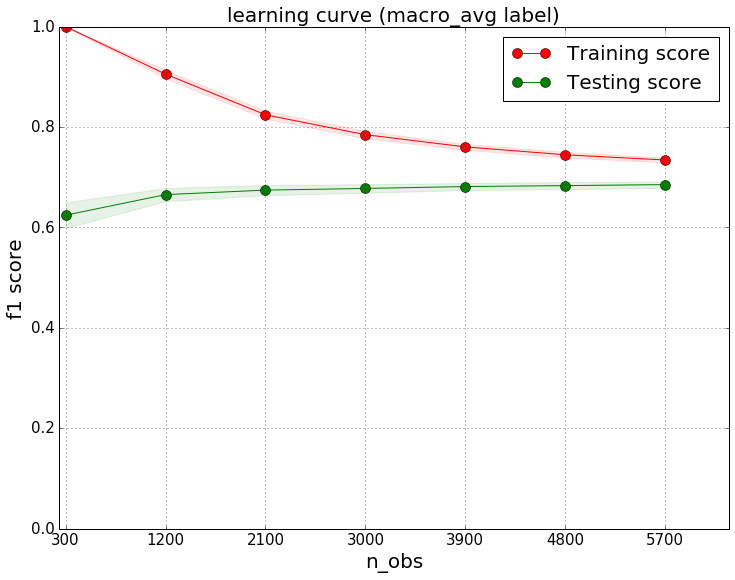

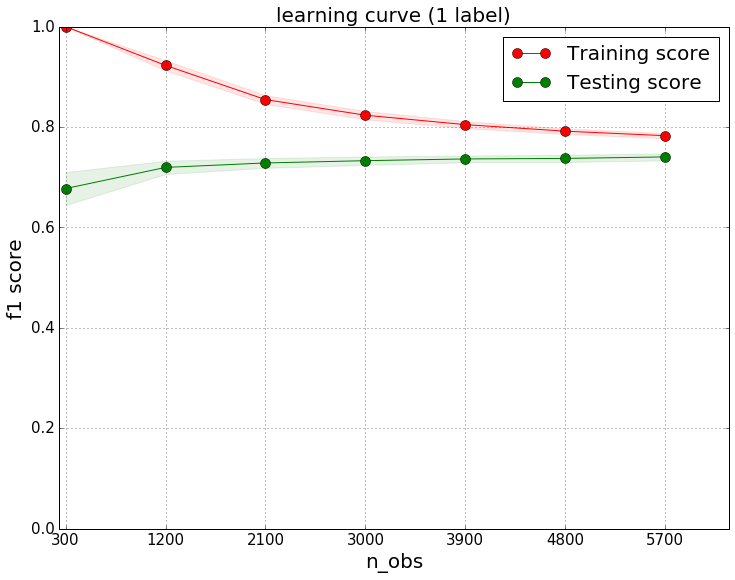

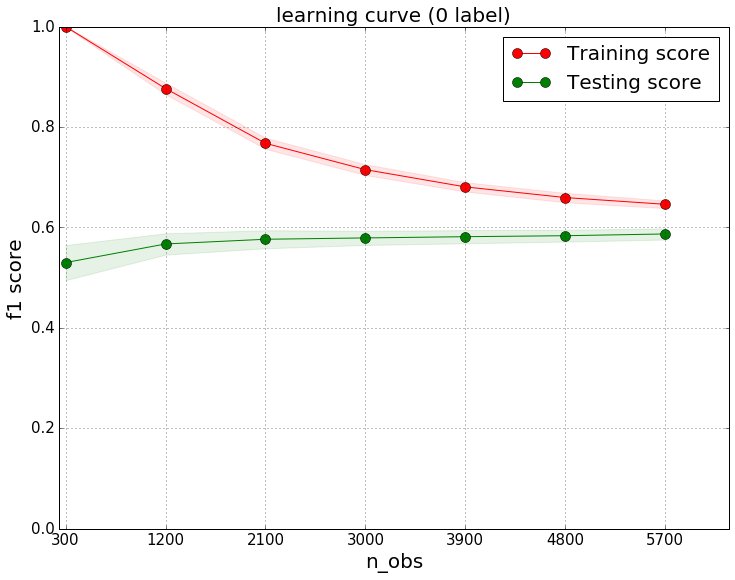

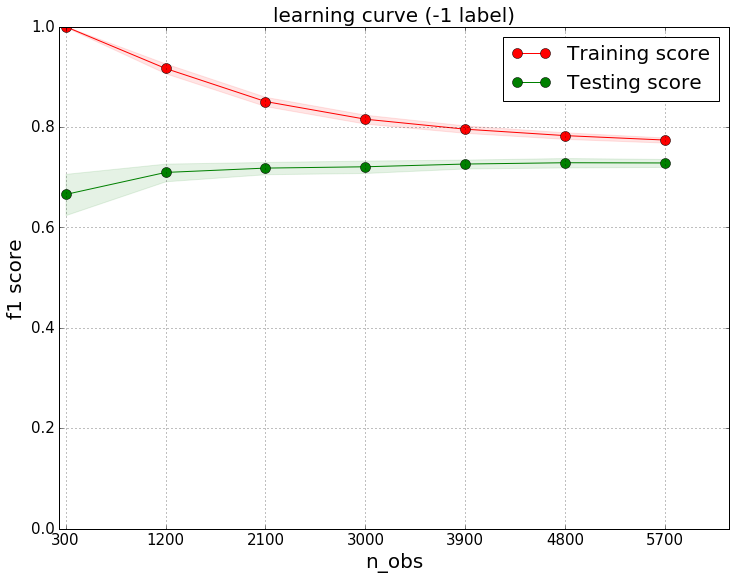

In [44]:
for label in ['macro_avg', '1', '0', '-1']:
    evaluator.plot_learning_curve(final_f1_df, label, 'n_obs')

## Loss function convergence 

In [45]:
history_path = "history/lstm_history.json"
with open(history_path, 'r') as fp:
    hist = json.load(fp)

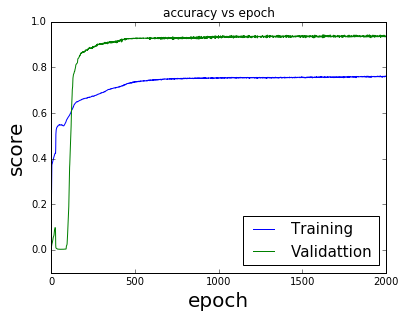

In [46]:
fig = plt.figure(figsize=(6, 4.5))
train_line = plt.plot(range(len(hist['acc'])), hist["acc"],  color="b", label="Training")
vald_line = plt.plot(range(len(hist['acc'])), hist["val_acc"], color="g", label="Validattion")
plt.legend(loc="best", fontsize=15)
plt.ylim(-0.1, 1)
plt.title("accuracy vs epoch")
plt.xlabel('epoch', fontsize=20)
plt.ylabel('score', fontsize=20)

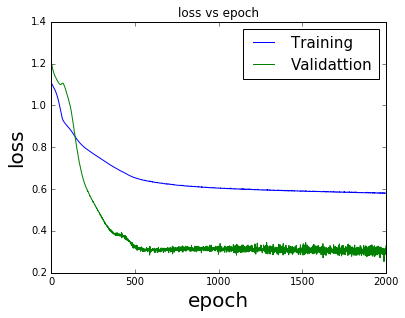

In [47]:
fig = plt.figure(figsize=(6, 4.5))
train_line = plt.plot(range(len(hist['loss'])), hist["loss"],  color="b", label="Training")
vald_line = plt.plot(range(len(hist['loss'])), hist["val_loss"], color="g", label="Validattion")
plt.legend(loc="best", fontsize=15)
plt.title("loss vs epoch")
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)

## LSTM Model Regression

An alternative approach to classification is to formulate the response as a continuous variable and predict the 'smart price' as a uni-variate time series. The smart price is the volume weighted mid-price, represented by feature_3 in our dataset.

### Data formatting

In [48]:
use_features = ['feature_3']
target = 'feature_3'
n_steps = 10

In [49]:
train_weight = 0.8
split = int(len(df)*train_weight)

In [50]:
df_train = df.iloc[:split]
std_df_train = df_train[use_features].apply(lambda x: (x - x.mean()) / x.std())
df_test = df.iloc[split:]
std_df_test = df[use_features].apply(lambda x: (x - x.mean()) / x.std()).iloc[split:]

In [51]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [52]:
x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(std_df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

In [53]:
col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

In [54]:
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].as_matrix()
x_train_reg = np.reshape(x_train_reg.as_matrix(), (x_train_reg.shape[0], x_train_reg.shape[1] / len(use_features), len(use_features)))

In [55]:
x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(std_df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

In [56]:
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].as_matrix()
x_test_reg = np.reshape(x_test_reg.as_matrix(), (x_test_reg.shape[0], x_test_reg.shape[1]/len(use_features), len(use_features)))

In [57]:
print x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape

(826815, 10, 1) (826815, 1) (206697, 10, 1) (206697, 1)


### Model Specification

In [58]:
reg_model = Sequential()
reg_model.add(LSTM(10, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
reg_model.add(Dense(1))
reg_model.compile(loss='mean_squared_error', optimizer='adam')

In [59]:
last_epoch_th = 0

In [60]:
reg_model.fit(x_train_reg, y_train_reg, epochs=1000, batch_size=500, verbose=1, initial_epoch = last_epoch_th)

Epoch 1/1000
 24000/826815 [..............................] - ETA: 104s - loss: 0.2189

KeyboardInterrupt: 

In [ ]:
# save the model
reg_model.save('model/lstm_regression_HFT.hdf5', overwrite=True)  # creates a HDF5 file 'my_model.h5'

In [63]:
# returns a compiled model
# identical to the previous one
reg_model = load_model('model/lstm_regression_HFT.hdf5')

### Prediction

In [64]:
%%time
# make predictions
pred_train = reg_model.predict(x_train_reg, verbose=1)
pred_test = reg_model.predict(x_test_reg, verbose=1)

206528/206697 [============================>.] - ETA: 0sCPU times: user 3min 42s, sys: 2min 30s, total: 6min 12s
Wall time: 3min 49s


### Plotting the model output

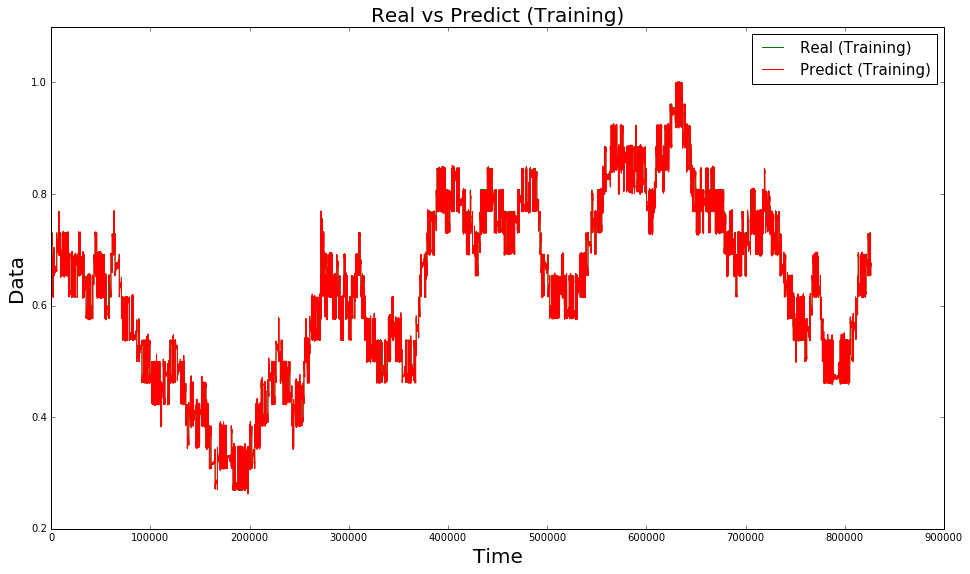

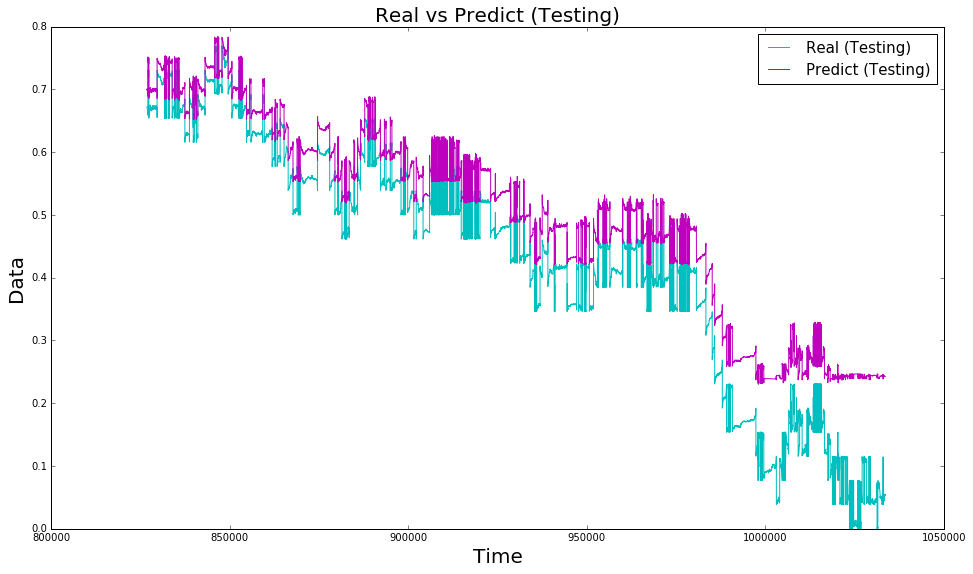

In [65]:
fig = plt.figure(figsize=(16,9))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="g", label="Real (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], pred_train[:, 0], color="r", label="Predict (Training)")
plt.legend(loc="best", fontsize=15)
plt.title('Real vs Predict (Training)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Data', fontsize=20)


fig = plt.figure(figsize=(16,9))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="c", label="Real (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], pred_test[:, 0], color="m", label="Predict (Testing)")
plt.legend(loc="best", fontsize=15)
plt.title('Real vs Predict (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Data', fontsize=20)

plt.show()

In [66]:
from sklearn.metrics import mean_squared_error

In [67]:
# calculate root mean squared error
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], pred_train[:, 0])
print MSE_train
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], pred_test[:, 0])
print MSE_test

1.53520347526e-05
0.00685378069555
